# Benchmark cancer cells annotation

The objective is to compare how well three different methods recover the annotated tumor cells.
The methods are `ikarus`, `inferCNV`, `scFusion` 

## Import libraries and data

In [57]:
import os
from pathlib import Path
import gdown

import pandas as pd
import anndata as ad

import scanpy as sc

from ikarus import classifier, utils, data

In [2]:
laughney_str = 'laughney_massague_2020_nsclc'
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'

This one is bigger than the ones that are already porccesed because it comes from SRA
and has been processed, by taking an elbow derivate of the cumulative sum of transcripts,
percentage of mitochondria and low number of transcripts.

In [3]:
adata = ad.read_h5ad(f'{data_dir}/{laughney_str}.h5ad')

# IMPORTANT we only use the tumor samples to avoid much variation
# adata = adata[(adata.obs.origin == 'tumor_primary') | (adata.obs.origin == 'normal')]
# adata = adata[(adata.obs.origin == 'tumor_primary')]
adata.obs

,sample,patient,origin,condition,tissue
120703408884123_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703409633700_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703423507166_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703423561070_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703436306869_0,GSM3516672,LX682,tumor_primary,LUAD,lung
...,...,...,...,...,...
241114576481206_16,GSM3516673,LX682,normal,LUAD,lung
241114577287974_16,GSM3516673,LX682,normal,LUAD,lung
241114589031734_16,GSM3516673,LX682,normal,LUAD,lung
241114589096668_16,GSM3516673,LX682,normal,LUAD,lung


## Intersect Ikarus vs Cell clusters

In [10]:
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'

if not Path(f"{data_dir}/laughney_ikarus.h5ad").is_file():
    gdown.download(
        "https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/laughney20_lung/adata.h5ad",
        f"{data_dir}/laughney_ikarus.h5ad"
    )
adata_ikarus = ad.read_h5ad(f'{data_dir}/laughney_ikarus.h5ad')    

    
archive = pd.HDFStore(f'{data_dir}/PATIENT_LUNG_ADENOCARCINOMA_ANNOTATED.h5', mode='r+')
pandas_laughney = archive['NDF_ALL']
archive.close()

# laughney_counts.loc[laughney_counts.index.PHENOGRAPH_CLASS('Meta-Source').isin(['NOR', 'TUMOR'])]

We check that they correspond to each other

In [8]:
adata_ikarus[:10,:30].to_df()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABC13-47488600E17.1,ABC13-47656900H15.1,ABCA1
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,1.943229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.509575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509575
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2.422809,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
pandas_laughney.iloc[:10,:].reset_index().iloc[:10,7:22]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.771797,0.0,0.000000
1,0.000000,0.0,2.382335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.264704,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361828,0.0,0.361828,0.0,0.000000
3,4.093525,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.046763,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272931,0.0,0.000000,0.0,0.000000
5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.773375,0.0,0.000000
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.751539,0.0,0.000000
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,3.141167
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


The cell correspond to each other but they have been scaled differently. Ikarus does not consider the actual library siz per cell but only 10^4 for all cells.

We convert the `pandas` dataframe to `AnnData`

In [17]:
# The main data for the AnnData object
index_names = pandas_laughney.index.names
pandas_laughney = pandas_laughney.reset_index()
X = pandas_laughney.iloc[:, len(index_names):] # Assuming the expression data starts after the multiindex columns

# Create an AnnData object with the expression data
adata_laughney = ad.AnnData(X=X)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [41]:
# Add the multiindex levels as metadata
# This assumes the first few columns are the multiindex levels
for level in index_names:
    #Strangely when using restore index, columns are not assigned well
    adata_laughney.obs[level] = pandas_laughney[level].array

In [47]:
del pandas_laughney

Get the indices of the cells that are marked as tumor in ikarus

In [43]:
ikarus_cancer = list(adata_ikarus.obs[adata_ikarus.obs.tier_0_hallmark_corrected == 'Tumor'].index)
ikarus_cancer = [int(entry) for entry in ikarus_cancer]

Check in what clusters of Laughney are the marked ikarus cells.

In [48]:
adata_laughney.obs['ascend'] = list(range(0,adata_laughney.obs.shape[0]))
adata_laughney.obs[adata_laughney.obs['ascend'].isin(ikarus_cancer)]['PHENOGRAPH_CLASS'].unique()

array(['2_MYELOID_OTHER', '1_MYELOID_OTHER', '7_MYELOID_OTHER',
       '21_MYELOID_OTHER', '28_MYELOID_OTHER', '17_MYELOID_OTHER',
       '36_MYELOID_OTHER', '25_MYELOID_OTHER', '15_MYELOID_OTHER',
       '4_MYELOID_OTHER', '3_MYELOID_OTHER', '10_MYELOID_OTHER',
       '8_MYELOID_OTHER', '35_MYELOID_OTHER', '12_MYELOID_OTHER',
       '38_MYELOID_OTHER', '0_MYELOID_OTHER', '16_MYELOID_OTHER',
       '9_MYELOID_OTHER', '24_MYELOID_OTHER', '20_MYELOID_OTHER',
       '37_MYELOID_OTHER', '6_MYELOID_OTHER', '13_MYELOID_OTHER',
       '22_MYELOID_OTHER', '26_MYELOID_OTHER', '5_LYMPHOID',
       '5_MYELOID_OTHER', '31_MYELOID_OTHER', '34_MYELOID_OTHER',
       '11_MYELOID_OTHER', '23_MYELOID_OTHER', '17_LYMPHOID',
       '29_MYELOID_OTHER'], dtype=object)

In [50]:
adata_laughney.obs['PHENOGRAPH_CLASS'].unique()

array(['0_LYMPHOID', '30_MYELOID_OTHER', '1_MYELOID_OTHER', '8_LYMPHOID',
       '9_LYMPHOID', '2_LYMPHOID', '10_MYELOID_OTHER', '17_MYELOID_OTHER',
       '10_LYMPHOID', '14_MYELOID_OTHER', '13_LYMPHOID',
       '2_MYELOID_OTHER', '25_MYELOID_OTHER', '20_MYELOID_OTHER',
       '6_LYMPHOID', '4_MYELOID_OTHER', '16_MYELOID_OTHER', '5_LYMPHOID',
       '18_MYELOID_OTHER', '3_MYELOID_OTHER', '11_LYMPHOID',
       '32_MYELOID_OTHER', '4_LYMPHOID', '15_LYMPHOID', '5_MYELOID_OTHER',
       '8_MYELOID_OTHER', '7_MYELOID_OTHER', '19_LYMPHOID',
       '13_MYELOID_OTHER', '22_MYELOID_OTHER', '21_MYELOID_OTHER',
       '0_MYELOID_OTHER', '6_MYELOID_OTHER', '3_LYMPHOID',
       '28_MYELOID_OTHER', '7_LYMPHOID', '15_MYELOID_OTHER',
       '14_LYMPHOID', '24_MYELOID_OTHER', '33_MYELOID_OTHER',
       '36_MYELOID_OTHER', '1_LYMPHOID', '35_MYELOID_OTHER',
       '38_MYELOID_OTHER', '12_LYMPHOID', '27_MYELOID_OTHER',
       '19_MYELOID_OTHER', '37_MYELOID_OTHER', '17_LYMPHOID',
       '34_MYELOID_OTHER

We can see that the cancer cells do not group in a cluster in particular, nor do they do it in the cell_types.
That is why to recover the 'expertly annotated cells' we must refer to the ikarus article, as they are not annotated in the original article.
After some search we can see that they declare how they annotated the tumor cells:

    For both input datasets, Laughney et al. lung adenocarcinoma and Lee et al. colorectal cancer, we considered a refined annotation for tumorous cells. Based on gene sets from MSigDB (v7.1) [49] hallmark collection HALLMARK_E2F_TARGETS, HALLMARK_G2M_CHECKPOINT, HALLMARK_MYC_TARGETS_V1, HALLMARK_MYC_TARGETS_V2, HALLMARK_P53_PATHWAY, HALLMARK_MITOTIC_SPINDLE, HALLMARK_HYPOXIA, HALLMARK_ANGIOGENESIS, and HALLMARK_GLYCOLYSIS, we scored each cell. If the average over all considered hallmark gene list scores (in the range 0–1) exceeds a reasonable threshold (0.45 for Laughney et al., 0.35 for Lee et al.), the cell is considered tumorous. Thresholds are chosen to minimize the amount of false positives with respect to the initial annotation of normal and tumor cell sources. The distribution of normal and tumor cell sources obtained from the initial annotation is provided in Additional File 2: Datasets.
    
**So the expert annotation is not very good because they train on a weak method to create a stronger method.**

Nevertheless we save the `ikarus` annotated tumor cells to our anndata object.

In [51]:
adata_laughney.obs['tier_0_hallmark_corrected'] = adata_ikarus.obs.tier_0_hallmark_corrected

In [52]:
del ikarus_cancer
del adata_ikarus

## **Ikarus**

#### Signatures

Here we just define the path of our gene signatures of choice (find more information on how the gene lists are created [here](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb).

Note: It is important that the name (see first column in the example) of the gene lists within the signatures.gmt file correspond to the cell type for which they are meaningful. signatures.gmt is tab-separated.


In [58]:
url = "https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt"
os.makedirs('out', exist_ok=True)
signatures_path = "out/signatures.gmt"
gdown.download(url, signatures_path, quiet=False)
pd.read_csv(signatures_path, sep="\t", header=None)

Downloading...
From: https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt
To: /root/host_home/luca/out/signatures.gmt
11.5kB [00:00, 8.90MB/s]                                                                                                                                                                                           


,0,1,2,3,4,5,6,7,8,9,...,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314
0,Normal,ikarus,RP11-128M1.1,TRAV8-2,PTPRD-AS1,MEOX2,CXCL12,KLRC4-KLRK1,BCAS1,SCNN1A,...,C22ORF15,CYP4F11,AK8,LRRC18,LMO2,COL12A1,ITGA11,EGFL6,RGS11,PCDHB15
1,Tumor,ikarus,RP11-277P12.10,RP13-895J2.6,BNC1,MAGEA6,ISX,MAGEA3,RP13-614K11.2,CDH7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We also download the the pretrained model which is based on the datasets by [Laughney et. al](https://www.nature.com/articles/s41591-019-0750-6) 
and [Lee et. al.](https://pubmed.ncbi.nlm.nih.gov/32451460/).
Which is a little bit redundant.

One can train the model on the dataset of choice. To see how to do that refer to the [tutorial](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb).

In [60]:
url = "https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/core_model.joblib"
os.makedirs('out', exist_ok=True)
model_path = "out/core_model.joblib"
gdown.download(url, model_path, quiet=False)

Downloading...
From: https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/core_model.joblib
To: /root/host_home/luca/out/core_model.joblib
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00k/1.00k [00:00<00:00, 2.32MB/s]


'out/core_model.joblib'

In [ ]:
data.preprocess_adata

In [289]:
adata = adata_tumor.copy()

In [290]:
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out",
                          # adapt_signatures=True # This is important, we are working with a reduced gen set, 
# so the model won't work if the intesrection betwen the siganture and the avialbe genes is too small..
# that is why the non-overlapping genes mus be removed from the signate. This flag does that automatically
                         ) 
model.load_core_model(model_path)

#### make prediction

We provide the AnnData of our data set, make predictions and save the results.
We use the connectivites defined by our batch-corrected embedding.

In [283]:
sparse.save_npz('scvi_conns.npz', adata.obsp['connectivities'])

In [291]:
adata.X = adata.layers['logcounts']
# adata = data.preprocess_adata(adata)

In [292]:
# This function works with the gene_symbol column, so we assign it
adata.var['gene_symbol'] = adata.var.index
_ = model.predict(adata, "laughney",
                  # connectivities_path='scvi_conns.npz', # If we use the connectivites from scVI the number of predicted cells changes a lot
                  save=True)

converged at iteration step: 14 with 0.0005 < 0.001


This next command computes the map but also creates the column for the colouring of the normal cells and the tumor cells

In [293]:
adata_tumor.obs["core_pred"] = model.results["core_pred"].values
adata_tumor.obs["final_pred"] = model.results["final_pred"].values

# We could use this function to calculate the umap automatically but we have already 
# done that so there is only need to get the labels
# _ = model.get_umap(adata, "laughney", save=True)

Load prediction results and the AnnData object including the just computed UMAP coordinates.

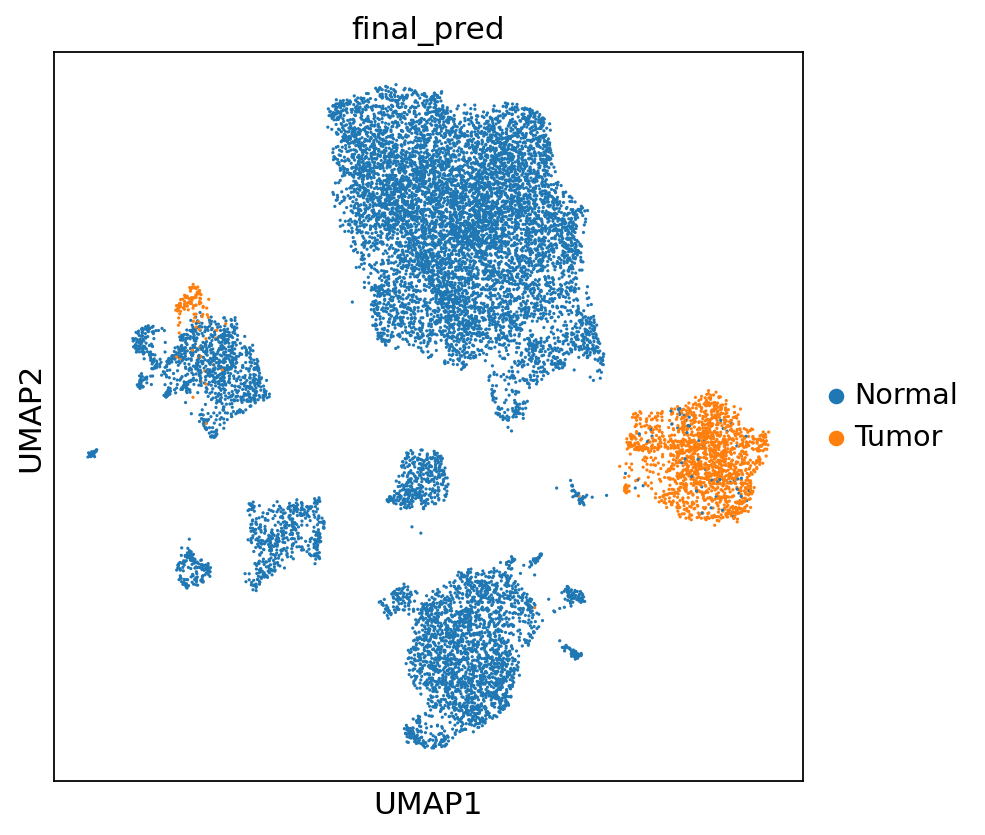

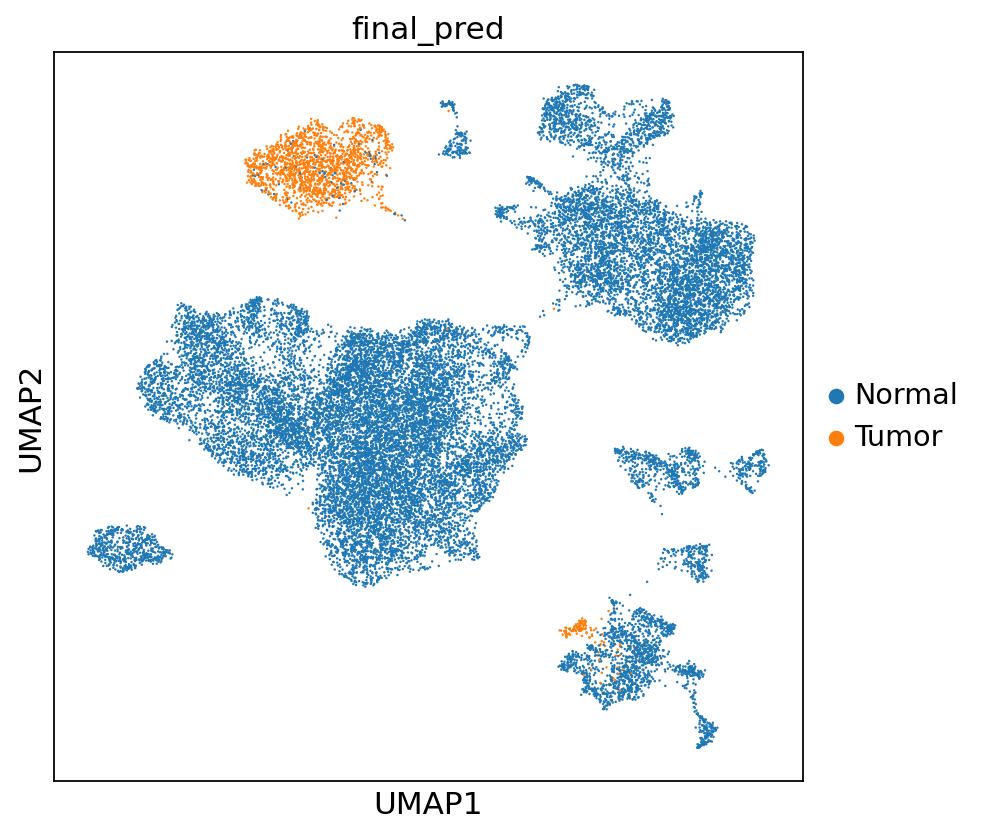

In [294]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata_tumor, color=['final_pred'])
sc.pl.umap(adata_both, color=['final_pred'])

Which leaves us with n cancer cells...

In [295]:
compare_df_tumor = pd.DataFrame()
adata_both_tumor = adata_both[adata_both.obs.origin == 'tumor_primary']

compare_df_tumor[f'final_pred'] = adata_tumor.obs[f"final_pred"]
compare_df_tumor[f'final_pred_both'] = adata_both_tumor.obs[f"final_pred"]

compare_df_tumor[f'core_pred'] = adata_tumor.obs[f"core_pred"]
compare_df_tumor[f'core_pred_both'] = adata_both_tumor.obs[f"core_pred"]

compare_df_tumor[f'same_core'] = (compare_df_tumor[f'core_pred'] == compare_df_tumor[f'core_pred_both'])
compare_df_tumor[f'same_final'] = (compare_df_tumor[f'final_pred'] == compare_df_tumor[f'final_pred_both'])

perc_same_final = 100*(compare_df_tumor[f'same_final'].sum()/compare_df_tumor.shape[0])
perc_same_core = 100*(compare_df_tumor[f'same_core'].sum()/compare_df_tumor.shape[0])

print(f'In the final level {perc_same_final}% are equal')
print(f'In the core level {perc_same_core}% are equal')

In the final level 99.84011122697254% are equal
In the core level 99.7566909975669% are equal


In [296]:
print((adata.obs['core_pred'] == 'Tumor').sum())
print((adata_both_tumor.obs['core_pred'] == 'Tumor').sum())

388
401


TODO: Use inferCNV to also check copy number aberrations

In [102]:
# path = "out/laughney"
# results = pd.read_csv(f'{path}/prediction.csv', index_col=0)
adata.write(f"{backup_dir}/adata_umap_ikarus.h5ad")
# adata = anndata.read_h5ad(f"{backup_dir}/adata_umap_ikarus.h5ad")